In [ ]:
# --------------------------
# Data Loading & Preparation
# --------------------------
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("husl")

# Verify dataset path exists
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset directory not found at {dataset_path}")

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Verify train/test directories exist
for path in [train_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Directory not found: {path}")

categories = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']

def load_data(directory):
    """Load image data with enhanced error handling and validation"""
    files, labels = [], []
    for category in categories:
        category_path = os.path.join(directory, category)
        if not os.path.exists(category_path):
            raise FileNotFoundError(f"Category directory missing: {category_path}")
            
        # Get valid image files
        valid_extensions = ('.png', '.jpg', '.jpeg')
        images = [f for f in os.listdir(category_path) 
                 if f.lower().endswith(valid_extensions)]
        
        if not images:
            raise ValueError(f"No valid images found in {category_path}")
            
        # Store metadata
        for img in images:
            img_path = os.path.join(category_path, img)
            if not os.path.isfile(img_path):
                print(f"Warning: Missing file {img_path}")
                continue
            files.append(img_path)
            labels.append(category)
    
    if not files:
        raise ValueError(f"No valid images found in {directory}")
        
    return pd.DataFrame({'filename': files, 'label': labels})

# Load data with validation
try:
    df_train = load_data(train_dir)
    df_test = load_data(test_dir)
except Exception as e:
    print(f"Data loading failed: {str(e)}")
    raise

print(f"\nLoaded samples:")
print(f"- Training: {len(df_train):,}")
print(f"- Test:     {len(df_test):,}")

# Train-validation split
try:
    train_df, val_df = train_test_split(
        df_train,
        test_size=0.2,
        stratify=df_train['label'],
        random_state=42
    )
except ValueError as e:
    print(f"Split failed: {str(e)}")
    raise

print(f"\nFinal dataset sizes:")
print(f"- Training:   {len(train_df):,}")
print(f"- Validation: {len(val_df):,}")
print(f"- Test:       {len(df_test):,}")

# --------------------------
# Enhanced Visualizations
# --------------------------

# 1. Sample Images Grid
plt.figure(figsize=(18, 12))
for idx, category in enumerate(categories):
    # Get 3 samples per category
    samples = train_df[train_df['label'] == category].sample(3, random_state=42)
    
    for j, (_, row) in enumerate(samples.iterrows()):
        ax = plt.subplot(6, 3, idx*3 + j + 1)  # 6 rows, 3 columns
        
        try:
            img = cv2.imread(row['filename'])
            if img is None:
                raise FileNotFoundError("Empty file")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(f"{category}\n{img.shape[:2]}px", fontsize=10)
        except Exception as e:
            plt.imshow(np.zeros((100, 100, 3)))
            plt.title(f"Error loading\n{os.path.basename(row['filename'])}", color='red', fontsize=8)
            plt.axis('off')

plt.suptitle("Sample Images from Each Category (with resolution)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# 2. Class Distribution Analysis
# Prepare data
dist_data = pd.concat([
    train_df['label'].rename('train'),
    val_df['label'].rename('val'),
    df_test['label'].rename('test')
], axis=1)

# Melt for seaborn
dist_melt = dist_data.melt(var_name='split', value_name='label')

plt.figure(figsize=(14, 6))
ax = sns.countplot(
    data=dist_melt,
    x='label',
    hue='split',
    order=categories
)

# Add annotations
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():,}", 
        (p.get_x() + p.get_width()/2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 5), 
        textcoords='offset points'
    )

plt.title("Class Distribution Across Dataset Splits", fontsize=14)
plt.xlabel("Class Name", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset Split')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Class Balance Table
print("\nClass Distribution Summary:")
print(pd.crosstab(dist_melt['label'], dist_melt['split'], margins=True))

In [ ]:
# ----------------------
# Data Augmentation
# ----------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='constant',
    cval=0.0  # Fill empty areas with black
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators with explicit class list
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    classes=categories,
    batch_size=64,  # Increased batch size for better performance
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='label',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    classes=categories,
    batch_size=64,
    shuffle=False
)

In [ ]:
# ----------------------
# Model Architecture
# ----------------------
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
# ----------------------
# Model Training
# ----------------------
from sklearn.utils.class_weight import compute_class_weight

# Get class weights
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Update ModelCheckpoint to use .keras extension
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model_resnet.keras',  # Changed extension to .keras
                    monitor='val_accuracy', 
                    save_best_only=True)
]

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# ----------------------
# Fine-Tuning
# ----------------------
# When loading the model later, use:
# model = tf.keras.models.load_model('best_model_resnet.keras')

In [ ]:
# ----------------------
# Fine-Tuning
# ----------------------
# Update 1: Change checkpoint filename extension
best_checkpoint = 'best_model_resnet.keras'

# Update 2: Add epoch printing callback
from tensorflow.keras.callbacks import LambdaCallback

epoch_print_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch+1}/{history.params['epochs']}")
)

# Update callback list
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint(best_checkpoint, monitor='val_accuracy', save_best_only=True),
    epoch_print_callback  # Add epoch tracking
]

# Unfreeze deeper layers
base_model.trainable = True
for layer in base_model.layers[:140]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning phase
history_fine = model.fit(
    train_generator,
    initial_epoch=history.epoch[-1] + 1,
    epochs=60,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Update 3: Load model with correct extension
from tensorflow.keras.models import load_model
model = load_model(best_checkpoint)  # Changed from load_weights to load_model

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Kaggle-specific paths
MODEL_PATH = '/kaggle/working/best_model_resnet.keras'  # Default Kaggle working directory

def kaggle_predict(image_path, show_image=True):
    """
    Kaggle-optimized prediction function
    
    Args:
        image_path (str): Path relative to Kaggle input directory
        show_image (bool): Whether to display the image
    
    Returns:
        tuple: (predicted_class, confidence)
    """
    # Load model (cached after first load)
    try:
        model = load_model(MODEL_PATH)
    except:
        raise ValueError("Model not found. Train first or check path!")
    
    # Full path for Kaggle input
    full_path = f'{image_path}'
    
    # Load and preprocess image
    try:
        img = image.load_img(full_path, target_size=(224, 224))
    except Exception as e:
        raise ValueError(f"Error loading {full_path}: {str(e)}")
    
    # Preprocess and predict
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    predictions = model.predict(img_array)
    predicted_idx = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100
    predicted_class = categories[predicted_idx]
    
    # Show results
    if show_image:
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.show()
    
    return predicted_class, round(confidence, 2)

# Example usage:
# 1. Upload your image to Kaggle (via Add Data button or notebook upload)
# 2. Use path like 'your-filename.jpg' if in main directory
#    or 'your-dataset-name/your-image.jpg' if added via dataset

# Try with a test image from the dataset first to verify
test_prediction = kaggle_predict("/kaggle/input/rotten/rotten.jpg")
print("\nTest prediction:", test_prediction)

# For your own image (uploaded via Kaggle's UI):
# your_prediction = kaggle_predict("your-uploaded-image.jpg")

In [ ]:
# --------------------------
# Evaluation Metrics (Corrected)
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load best model
model = load_model('/kaggle/working/best_model_resnet.keras')

# Prepare test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filename',
    y_col='label',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    classes=categories,
    batch_size=64,
    shuffle=False
)

# Get predictions
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification Report
print("📊 Comprehensive Classification Report:")
clf_report = classification_report(
    y_true,
    y_pred,
    target_names=categories,
    digits=4,
    output_dict=True
)

# Calculate specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec = []
    for i in range(len(categories)):
        tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
        fp = cm[:,i].sum() - cm[i,i]
        spec.append(tn / (tn + fp))
    return spec

# Create class-specific metrics dataframe
class_report = pd.DataFrame(clf_report).transpose()
specificities = specificity_score(y_true, y_pred)

# Add specificity to class rows only
class_report['specificity'] = np.nan
for i, cat in enumerate(categories):
    class_report.loc[cat, 'specificity'] = specificities[i]

print("\n🔍 Enhanced Classification Report:")
print(class_report[['precision', 'recall', 'f1-score', 'specificity', 'support']])

# Confusion Matrix (Absolute Values)
plt.figure(figsize=(14, 10))
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories,
    cbar=False
)

plt.title('Confusion Matrix (Absolute Counts)', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
plt.figure(figsize=(14, 10))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=categories,
    yticklabels=categories
)

plt.title('Normalized Confusion Matrix (% of True Class)', fontsize=14)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------
# Core Dependencies
# ----------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow Components
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input

# Visual Setup
plt.style.use('ggplot')
sns.set_palette("husl")


In [ ]:
# ----------------------
# Path Configuration
# ----------------------
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
categories = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']

# Verify paths
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

In [ ]:
# ----------------------
# DataFrame Creation
# ----------------------
def create_dataframe(directory):
    image_paths = []
    labels = []
    
    for category in categories:
        cat_path = os.path.join(directory, category)
        for img_name in os.listdir(cat_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(cat_path, img_name))
                labels.append(category)
    
    return pd.DataFrame({
        'image_path': image_paths,
        'category': labels
    })

# Load data
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [ ]:
# ----------------------
# Train-Validation Split
# ----------------------
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['category'],
    random_state=42
)

In [ ]:
# ----------------------
# EfficientNet Generators
# ----------------------
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

# Create generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
def build_model():
    # Base model with proper parenthesis
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)  # Added closing parenthesis
    )  # Added closing parenthesis for the base model
    
    # Freezing layers
    for layer in base_model.layers:
        layer.trainable = False
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
    
    # Custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(len(categories), activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=outputs)

model = build_model()

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Initial training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Fine-tuning preparation
for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=history.epoch[-1] + 1,
    epochs=60,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Load best model
model = load_model('best_model.keras')

# Test generator
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    class_mode='sparse',
    classes=categories,
    batch_size=64,
    shuffle=False
)

# Predictions
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Metrics
print(classification_report(
    y_true,
    y_pred,
    target_names=categories,
    digits=4
))

# Confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(
    confusion_matrix(y_true, y_pred),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories
)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# ----------------------
# Performance Analysis
# ----------------------
model = load_model('best_model.keras')

# Generate predictions
y_pred = np.argmax(model.predict(test_gen), axis=1)
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=categories))

# Confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(y_true, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
def predict_fruit(image_path):
    """Predict fruit freshness from image path"""
    try:
        # Load and preprocess image
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        preds = model.predict(img_array)
        pred_class = categories[np.argmax(preds)]
        confidence = np.max(preds) * 100
        
        # Display results
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%")
        plt.show()
        
        return pred_class, round(confidence, 2)
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None, None

# Example usage
class_name, confidence = predict_fruit("/kaggle/input/rotten/rotten.jpg")
print(f"Prediction: {class_name} ({confidence}% confidence)")

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

plt.style.use('ggplot')
sns.set_palette("husl")


In [ ]:
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
categories = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')


In [ ]:
def create_dataframe(directory):
    image_paths = []
    labels = []
    for category in categories:
        cat_path = os.path.join(directory, category)
        for img_name in os.listdir(cat_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(cat_path, img_name))
                labels.append(category)
    return pd.DataFrame({'image_path': image_paths, 'category': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)


In [ ]:
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['category'],
    random_state=42
)

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['category']),
    y=train_df['category']
)
class_weight_dict = dict(zip(np.unique(train_df['category']), class_weights))


In [ ]:
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True,
    classes=categories
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False,
    classes=categories
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False,
    classes=categories
)


In [ ]:
def build_mobilenet():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
        if isinstance(layer, BatchNormalization):
            layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(len(categories), activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=outputs)

model = build_mobilenet()


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
for layer in model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=history.epoch[-1] + 1,
    epochs=60,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
model = load_model('best_model.keras')

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(classification_report(
    y_true,
    y_pred,
    target_names=categories,
    digits=4
))

plt.figure(figsize=(12,10))
sns.heatmap(
    confusion_matrix(y_true, y_pred),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories
)
plt.title('MobileNetV2 Confusion Matrix')
plt.show()


In [ ]:
def predict_fruit(image_path):
    try:
        model = load_model('best_model.keras')
        img = load_img(image_path, target_size=(224, 224))
        img_array = preprocess_input(img_to_array(img))
        img_array = np.expand_dims(img_array, axis=0)

        preds = model.predict(img_array)
        pred_class = categories[np.argmax(preds)]
        confidence = np.max(preds) * 100

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%")
        plt.show()

        return pred_class, round(confidence, 2)
    except Exception as e:
        print(f"Error: {str(e)}")
        return None, None


In [ ]:
# Replace with your own image
class_name, confidence = predict_fruit("/kaggle/input/rotten/rotten.jpg")
print(f"Prediction: {class_name} ({confidence}% confidence)")


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

plt.style.use('ggplot')
sns.set_palette("husl")


In [ ]:
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
categories = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

def create_dataframe(directory):
    image_paths, labels = [], []
    for category in categories:
        category_path = os.path.join(directory, category)
        for img_file in os.listdir(category_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(category_path, img_file))
                labels.append(category)
    return pd.DataFrame({'image_path': image_paths, 'category': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['category'], random_state=42)


In [ ]:
BATCH_SIZE = 64
TARGET_SIZE = (227, 227)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='category',
                                              target_size=TARGET_SIZE, class_mode='sparse',
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='category',
                                          target_size=TARGET_SIZE, class_mode='sparse',
                                          batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
def fire_module(x, squeeze, expand):
    x = Conv2D(squeeze, (1, 1), activation='relu')(x)
    left = Conv2D(expand, (1, 1), activation='relu')(x)
    right = Conv2D(expand, (3, 3), padding='same', activation='relu')(x)
    return concatenate([left, right])

def build_squeezenet(input_shape=(227, 227, 3), num_classes=6):
    inputs = Input(shape=input_shape)
    x = Conv2D(96, (7, 7), strides=(2, 2), padding='valid', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = Dropout(0.5)(x)
    x = Conv2D(num_classes, (1, 1), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    return Model(inputs, output)

model = build_squeezenet()


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.2, patience=4, min_lr=1e-7),
    ModelCheckpoint('best_squeezenet.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks, verbose=1)


In [ ]:
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='category',
                                            target_size=TARGET_SIZE, class_mode='sparse',
                                            batch_size=64, shuffle=False)

model = tf.keras.models.load_model('best_squeezenet.keras')

y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=categories))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def predict_fruit(image_path):
    try:
        img = load_img(image_path, target_size=TARGET_SIZE)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        preds = model.predict(img_array)
        pred_class = categories[np.argmax(preds)]
        confidence = np.max(preds) * 100

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {pred_class} ({confidence:.2f}%)")
        plt.show()
        
        return pred_class, round(confidence, 2)
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Example usage
predict_fruit("/kaggle/input/rotten/rotten.jpg")


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path and categories
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'
categories = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
train_dir = os.path.join(dataset_path, 'train')
test_dir  = os.path.join(dataset_path, 'test')

# Create a DataFrame from a directory
def create_dataframe(directory):
    image_paths, labels = [], []
    for category in categories:
        category_path = os.path.join(directory, category)
        for img_file in os.listdir(category_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(category_path, img_file))
                labels.append(category)
    return pd.DataFrame({'image_path': image_paths, 'category': labels})

# Create DataFrames for training and testing
train_df = create_dataframe(train_dir)
test_df  = create_dataframe(test_dir)

# Split training data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['category'], random_state=42)

# Configure ImageDataGenerators for preprocessing
BATCH_SIZE = 64
TARGET_SIZE = (227, 227)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Create generators from the DataFrames
train_gen = train_datagen.flow_from_dataframe(train_df, 
                                              x_col='image_path', 
                                              y_col='category',
                                              target_size=TARGET_SIZE, 
                                              class_mode='sparse',
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True)

val_gen = val_datagen.flow_from_dataframe(val_df, 
                                          x_col='image_path', 
                                          y_col='category',
                                          target_size=TARGET_SIZE, 
                                          class_mode='sparse',
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)


Found 8720 validated image filenames belonging to 6 classes.
Found 2181 validated image filenames belonging to 6 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Activation, MaxPooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Custom Layers for ShuffleNet
class ChannelShuffle(Layer):
    def __init__(self, groups, **kwargs):
        super().__init__(**kwargs)
        self.groups = groups

    def call(self, inputs):
        shape = tf.shape(inputs)
        batch_size = shape[0]
        height = shape[1]
        width = shape[2]
        channels = shape[3]
        
        group_channels = channels // self.groups
        x = tf.reshape(inputs, [batch_size, height, width, self.groups, group_channels])
        x = tf.transpose(x, perm=[0, 1, 2, 4, 3])
        return tf.reshape(x, [batch_size, height, width, channels])

    def compute_output_shape(self, input_shape):
        return input_shape

class ChannelSplit(Layer):
    def __init__(self, split_index, **kwargs):
        super().__init__(**kwargs)
        self.split_index = split_index

    def call(self, inputs):
        return (inputs[..., :self.split_index], 
                inputs[..., self.split_index:])

    def compute_output_shape(self, input_shape):
        return [
            (input_shape[0], input_shape[1], input_shape[2], self.split_index),
            (input_shape[0], input_shape[1], input_shape[2], input_shape[3] - self.split_index)
        ]

# ShuffleNet Components
def conv_branch(x, out_channels, stride):
    x = Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def shuffle_unit(x, out_channels, stride):
    half_channels = out_channels // 2
    if stride == 1:
        x1, x2 = ChannelSplit(half_channels)(x)
        y1 = x1
        y2 = conv_branch(x2, half_channels, stride)
    else:
        y1 = conv_branch(x, half_channels, stride)
        y2 = conv_branch(x, half_channels, stride)
    out = Concatenate()([y1, y2])
    return ChannelShuffle(groups=2)(out)

# Build ShuffleNet
def build_shufflenet():
    inputs = Input(shape=(227, 227, 3))
    
    # Initial layers
    x = Conv2D(24, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Stage blocks
    x = Conv2D(240, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    for _ in range(4): x = shuffle_unit(x, 240, 1)
    x = shuffle_unit(x, 480, 2)
    
    for _ in range(8): x = shuffle_unit(x, 480, 1)
    x = shuffle_unit(x, 960, 2)
    
    for _ in range(4): x = shuffle_unit(x, 960, 1)
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(6, activation='softmax')(x)
    
    return Model(inputs, outputs)



In [4]:
# Create and compile model
from tensorflow.keras.optimizers import Adam  # This is the missing import

model = build_shufflenet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.2, patience=4, min_lr=1e-7),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

# Evaluation (add this after training)
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='category',
    target_size=TARGET_SIZE,
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Load best model for evaluation
model = tf.keras.models.load_model('best_model.keras', 
                                  custom_objects={
                                      'ChannelShuffle': ChannelShuffle,
                                      'ChannelSplit': ChannelSplit
                                  })

# Evaluate
loss, acc = model.evaluate(test_gen)
print(f"\nTest accuracy: {acc:.2%}")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.4154 - loss: 1.4359 - val_accuracy: 0.1463 - val_loss: 1.7983 - learning_rate: 1.0000e-04
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 64s 450ms/step - accuracy: 0.8537 - loss: 0.4091 - val_accuracy: 0.1463 - val_loss: 1.8595 - learning_rate: 1.0000e-04
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 63s 444ms/step - accuracy: 0.9121 - loss: 0.2498 - val_accuracy: 0.1463 - val_loss: 2.7385 - learning_rate: 1.0000e-04
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 65s 453ms/step - accuracy: 0.9399 - loss: 0.1786 - val_accuracy: 0.1463 - val_loss: 7.4112 - learning_rate: 1.0000e-04
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 65s 459ms/step - accuracy: 0.9431 - loss: 0.1593 - val_accuracy: 0.4805 - val_loss: 1.9411 - learning_rate: 1.0000e-04
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 64s 451ms/step - accuracy: 0.9644 - loss: 0.1033 - val_accuracy: 0.9477 - val_loss: 0.1526 - learning_rate: 2.0000e-05
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 65s 457ms/step - ac

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 770ms/step - accuracy: 0.9855 - loss: 0.0460

Test accuracy: 98.55%


In [9]:
# Generate predictions
y_pred_probs = model.predict(test_gen)
y_pred = y_pred_probs.argmax(axis=1)

# True labels
y_true = test_gen.classes

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=categories, columns=categories)

cr = classification_report(y_true, y_pred, target_names=categories)


print("\nClassification Report:")
print(cr)

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 330ms/step

Classification Report:
               precision    recall  f1-score   support

  freshapples       0.99      0.99      0.99       395
  freshbanana       0.99      0.99      0.99       381
 freshoranges       0.98      0.99      0.99       388
 rottenapples       0.98      0.97      0.98       601
 rottenbanana       0.99      1.00      1.00       530
rottenoranges       0.97      0.99      0.98       403

     accuracy                           0.99      2698
    macro avg       0.99      0.99      0.99      2698
 weighted avg       0.99      0.99      0.99      2698



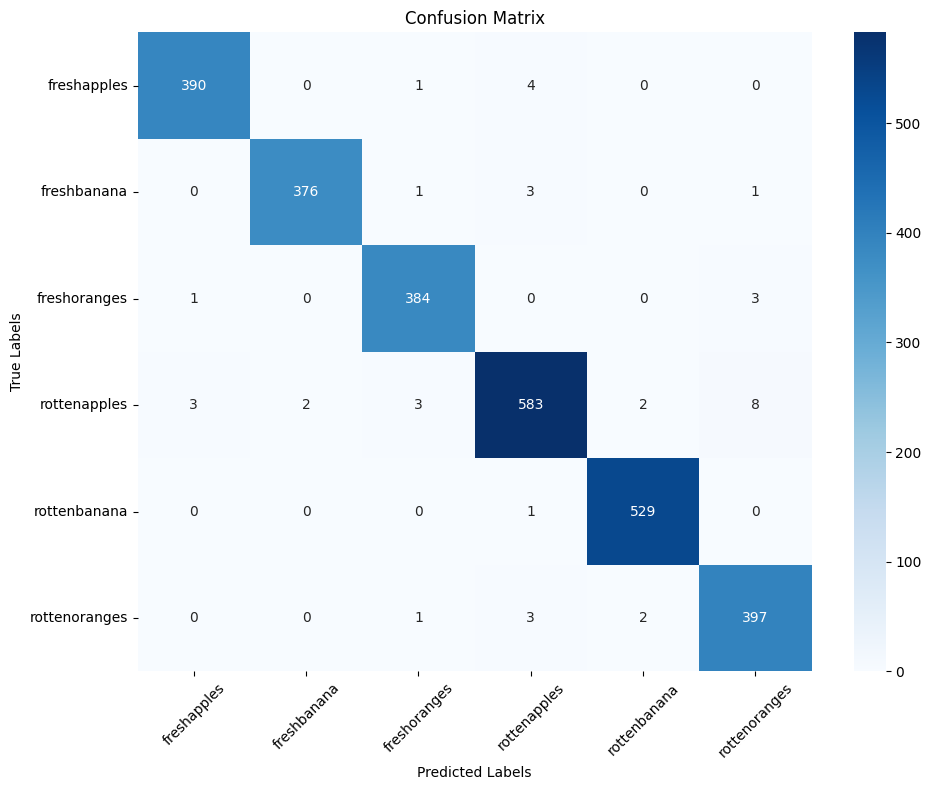

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

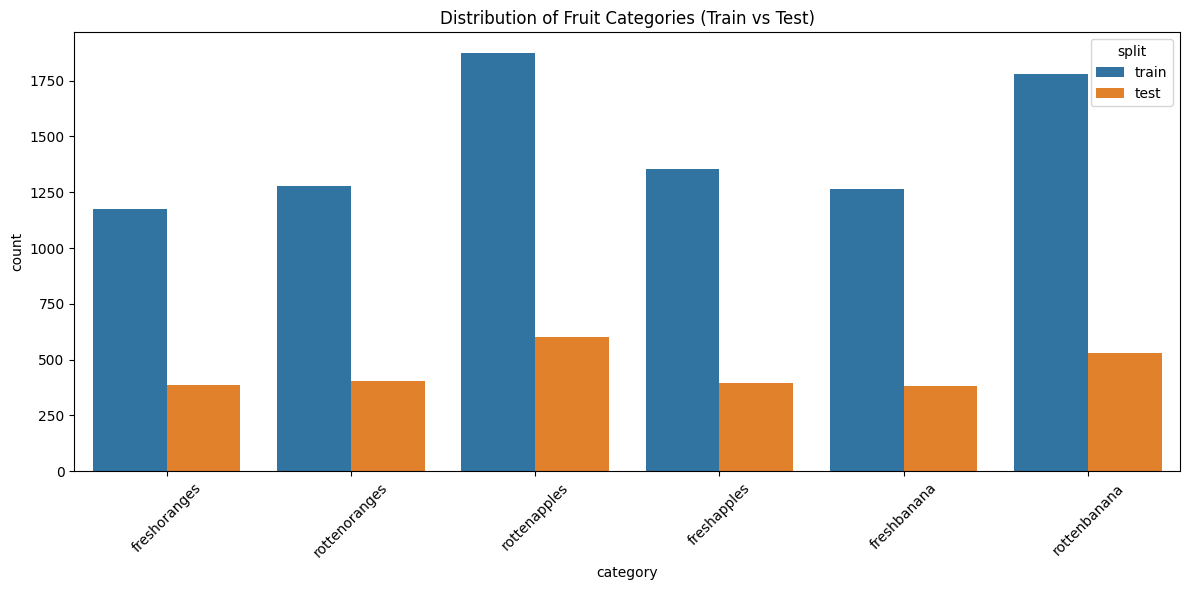

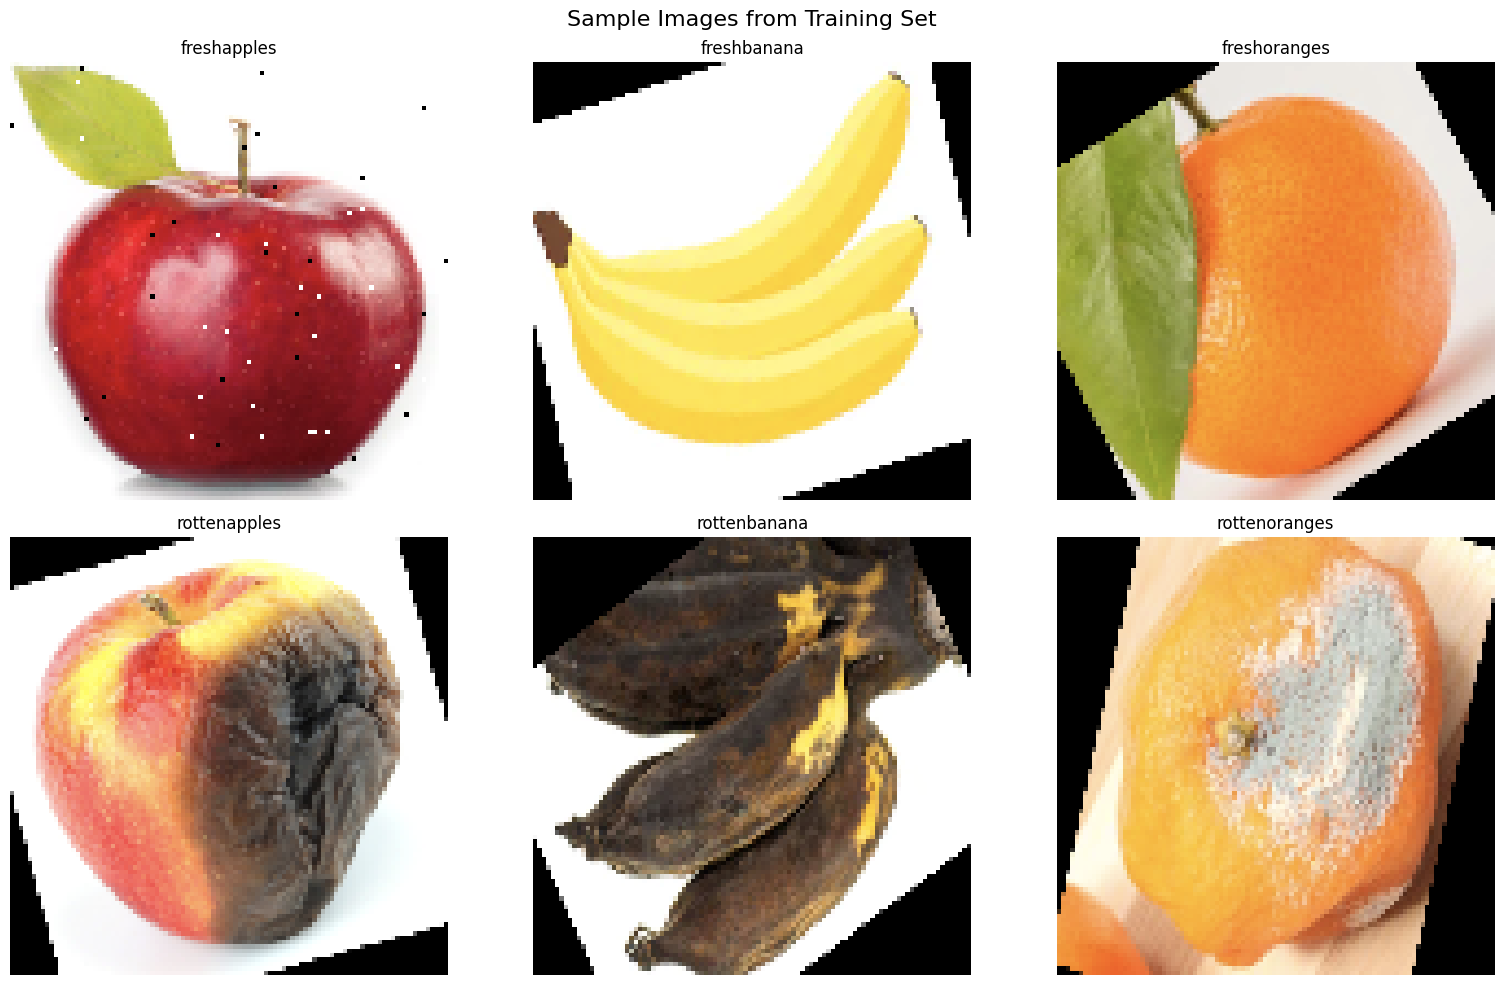

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


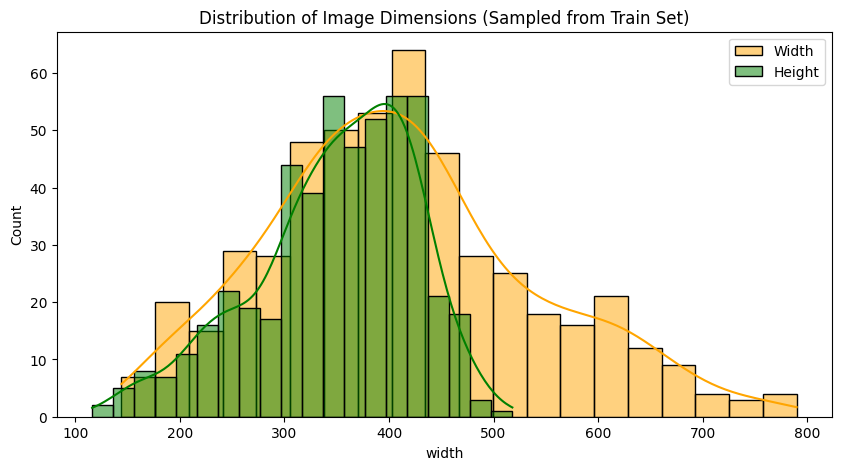

🧾 Total images in training set: 8720
🧾 Total images in test set: 2698

📊 Category counts (Train):
category
rottenapples     1873
rottenbanana     1779
freshapples      1354
rottenoranges    1276
freshbanana      1265
freshoranges     1173
Name: count, dtype: int64


In [12]:
# ------------------ 4. Exploratory Data Analysis (EDA) ------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import load_img  # <-- Add this line

# ------------------ 4. Exploratory Data Analysis (EDA) ------------------

# Merge train and test for a broader overview
full_df = pd.concat([train_df.assign(split='train'), test_df.assign(split='test')])

# 1. Category Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=full_df, x='category', hue='split')
plt.title('Distribution of Fruit Categories (Train vs Test)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Sample Images From Each Class
def plot_sample_images(df, title):
    plt.figure(figsize=(16, 10))
    for i, cat in enumerate(categories):
        sample = df[df['category'] == cat].sample(1).iloc[0]
        img = load_img(sample.image_path, target_size=(100, 100))
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(cat)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_sample_images(train_df, "Sample Images from Training Set")

# 3. Image Size Distribution (Optional but Insightful)
image_shapes = []
for path in train_df['image_path'].sample(500):  # limit for performance
    img = load_img(path)
    image_shapes.append(img.size)  # (width, height)

shape_df = pd.DataFrame(image_shapes, columns=['width', 'height'])

plt.figure(figsize=(10, 5))
sns.histplot(shape_df['width'], bins=20, color='orange', kde=True, label='Width')
sns.histplot(shape_df['height'], bins=20, color='green', kde=True, label='Height')
plt.legend()
plt.title("Distribution of Image Dimensions (Sampled from Train Set)")
plt.show()

# 4. Total Image Count
print("🧾 Total images in training set:", len(train_df))
print("🧾 Total images in test set:", len(test_df))
print("\n📊 Category counts (Train):")
print(train_df['category'].value_counts())


Analyze DF contains 100 valid samples
Categories present: ['rottenapples' 'freshbanana' 'freshapples' 'rottenbanana' 'freshoranges'
 'rottenoranges']


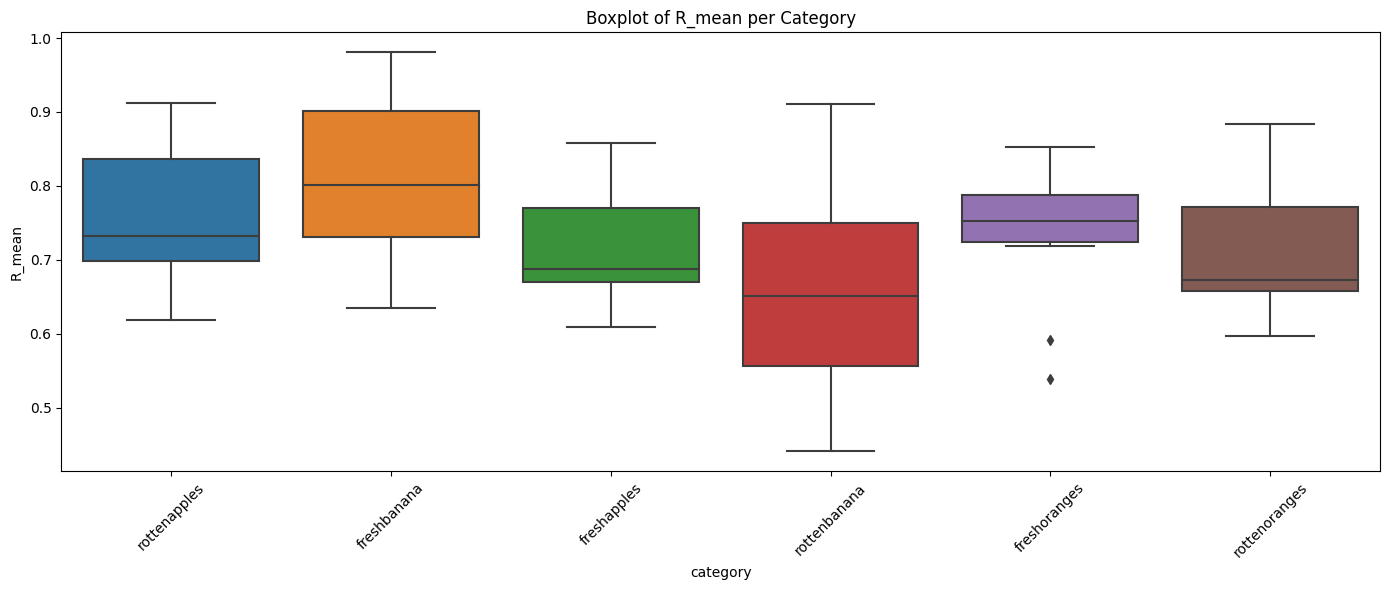

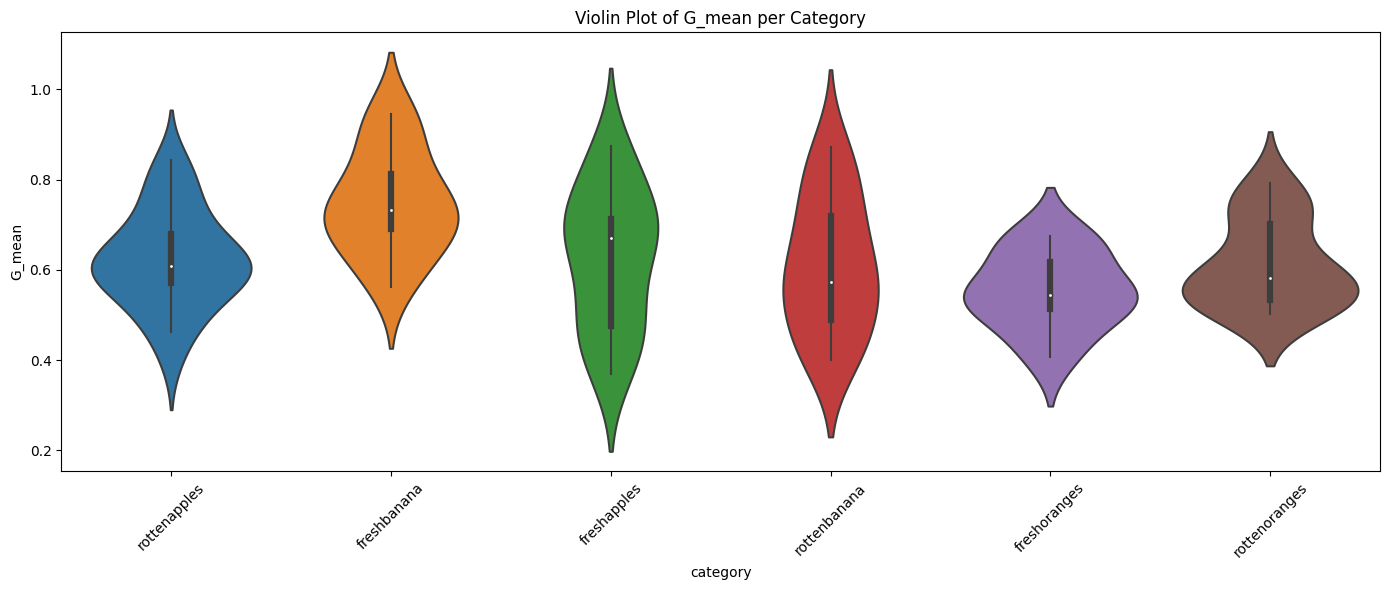

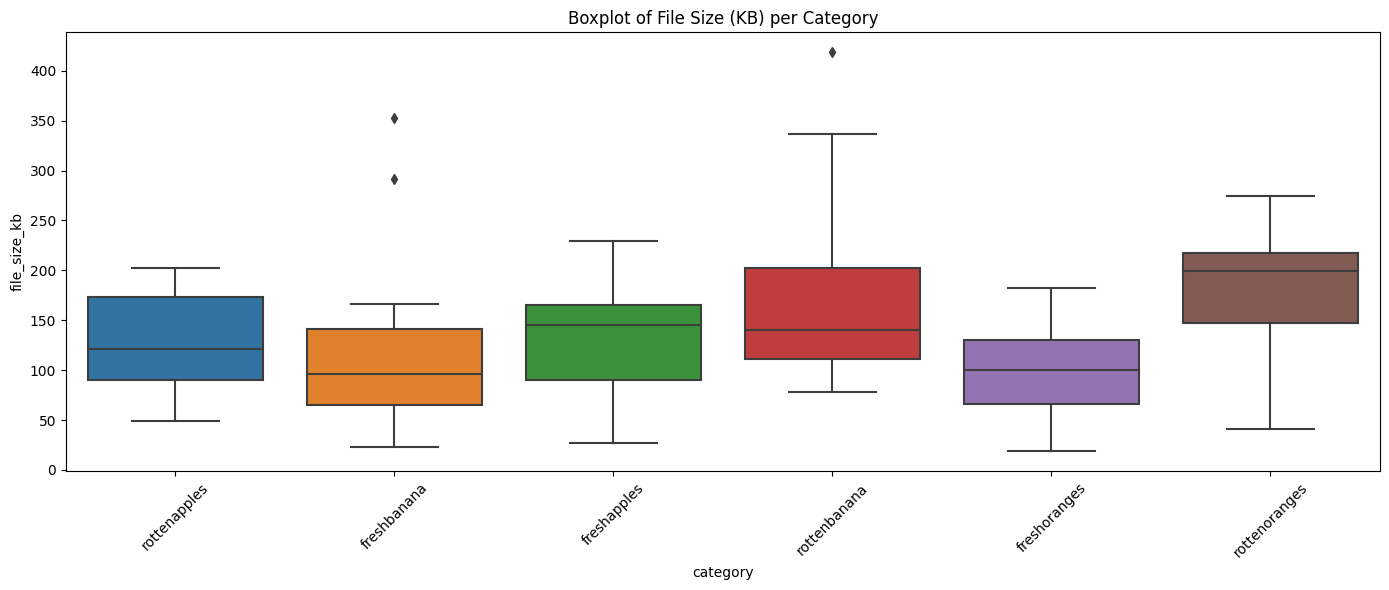

In [17]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Dataset path
dataset_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset'

# 1. Create DataFrame with image paths and labels
def create_dataframe(dataset_path, split='train'):
    classes = ['freshapples', 'freshbanana', 'freshoranges',
               'rottenapples', 'rottenbanana', 'rottenoranges']
    
    image_paths = []
    categories = []
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, split, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist, skipping")
            continue
            
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_path, img_file)
                image_paths.append(img_path)
                categories.append(class_name)
                
    return pd.DataFrame({'image_path': image_paths, 'category': categories})

# Create train dataframe
train_df = create_dataframe(dataset_path, split='train')

# 2. Feature extraction
TARGET_SIZE = (224, 224)

def extract_features_for_analysis(df):
    features = []
    for path in df['image_path']:
        try:
            img = load_img(path, target_size=TARGET_SIZE)
            img_array = img_to_array(img) / 255.0

            features.append([
                path,
                np.mean(img_array[:, :, 0]),  # R mean
                np.mean(img_array[:, :, 1]),  # G mean
                np.mean(img_array[:, :, 2]),  # B mean
                img_array.shape[1] / img_array.shape[0],  # Aspect ratio
                os.path.getsize(path) / 1024  # File size in KB
            ])
        except Exception as e:
            print(f"Error loading {path}: {str(e)}")
            continue

    feature_df = pd.DataFrame(features, 
                              columns=['image_path', 'R_mean', 'G_mean', 'B_mean', 
                                       'aspect_ratio', 'file_size_kb'])
    return df.merge(feature_df, on='image_path', how='inner')

# 3. Sample and analyze
analyze_df = extract_features_for_analysis(train_df.sample(100, random_state=42))

print(f"Analyze DF contains {len(analyze_df)} valid samples")
print("Categories present:", analyze_df['category'].unique())

# 4. Visualize results
if not analyze_df.empty:
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=analyze_df, x='category', y='R_mean')
    plt.xticks(rotation=45)
    plt.title("Boxplot of R_mean per Category")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.violinplot(data=analyze_df, x='category', y='G_mean')
    plt.xticks(rotation=45)
    plt.title("Violin Plot of G_mean per Category")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=analyze_df, x='category', y='file_size_kb')
    plt.xticks(rotation=45)
    plt.title("Boxplot of File Size (KB) per Category")
    plt.tight_layout()
    plt.show()
else:
    print("No valid images found - check path structure and file permissions")


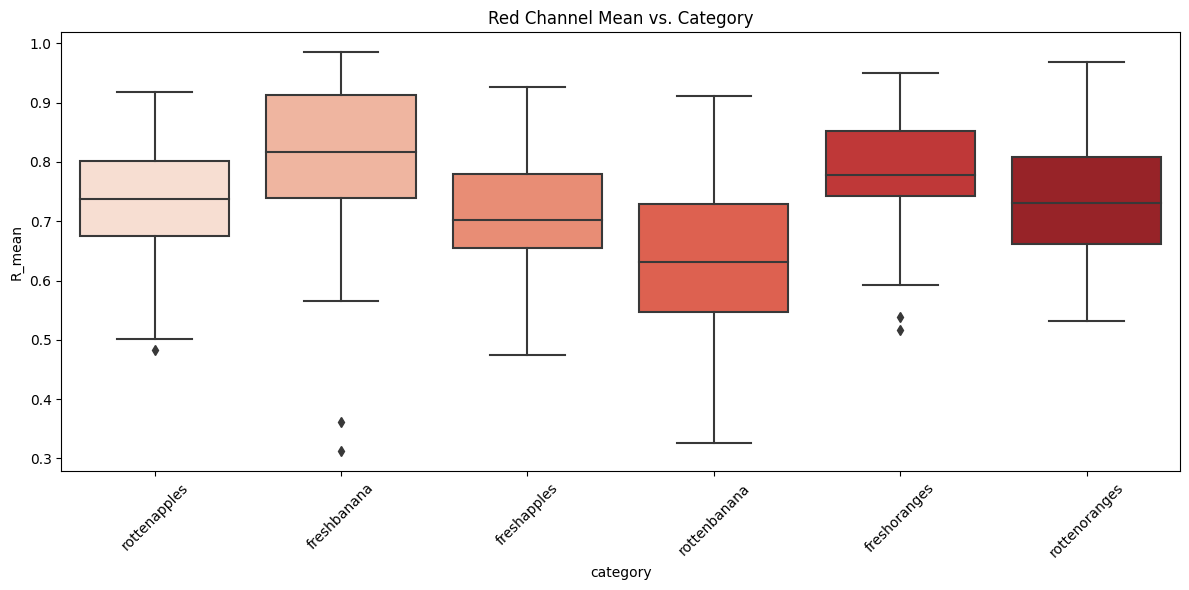

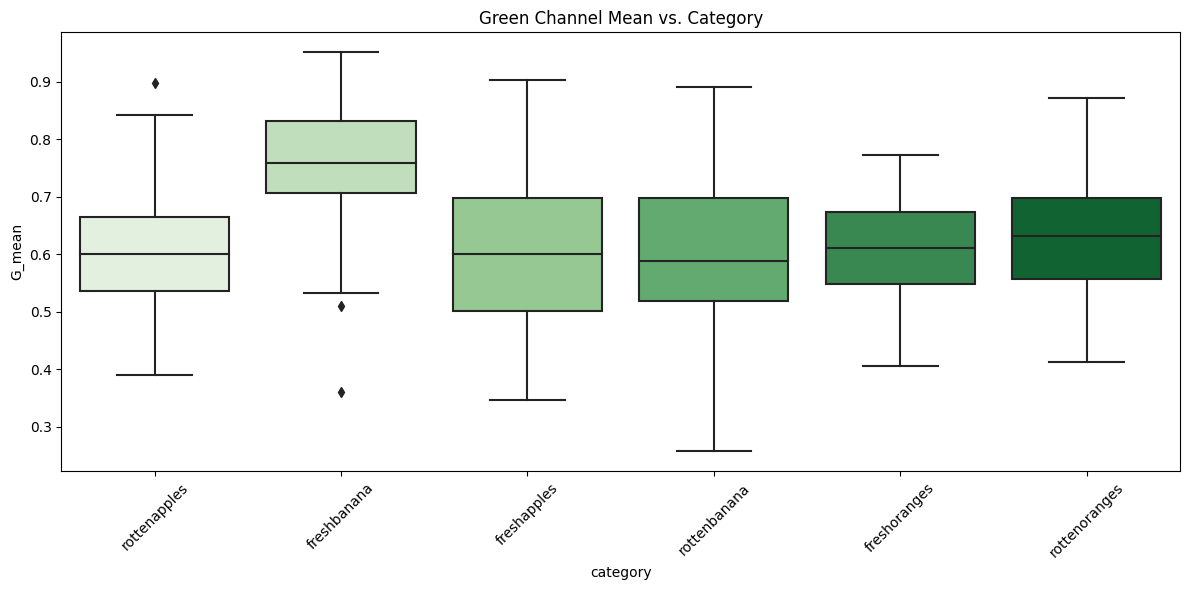

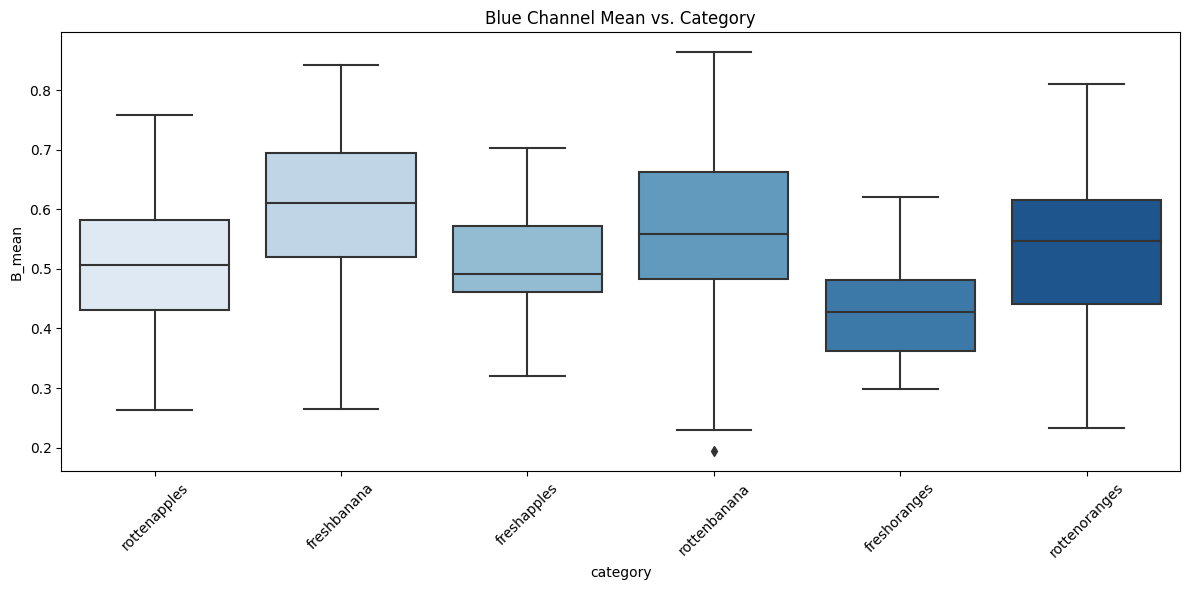

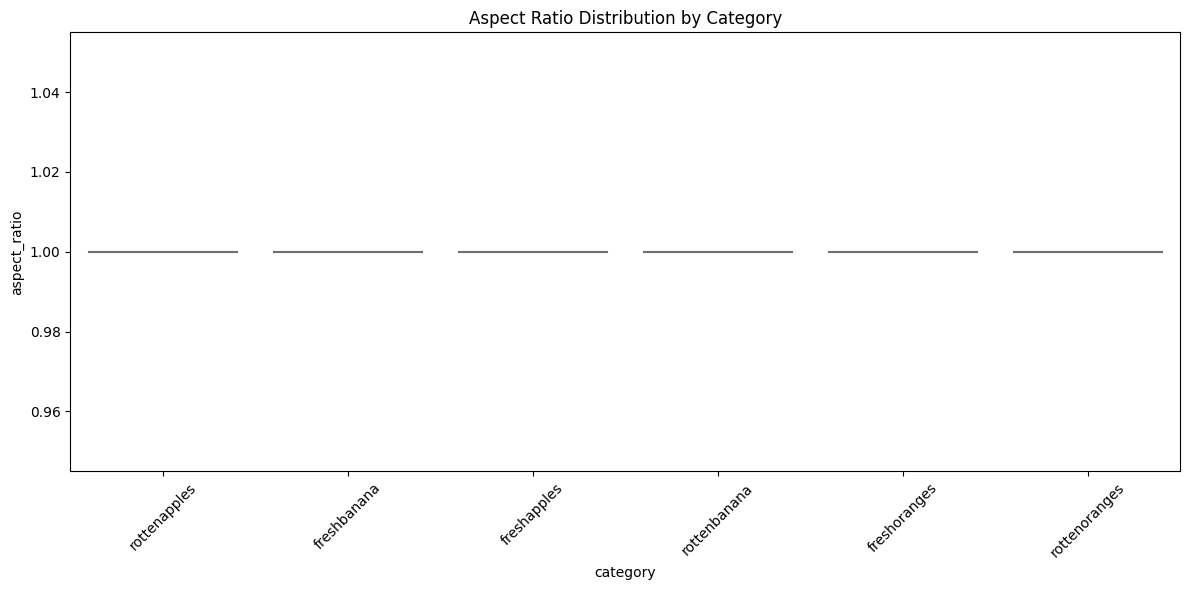

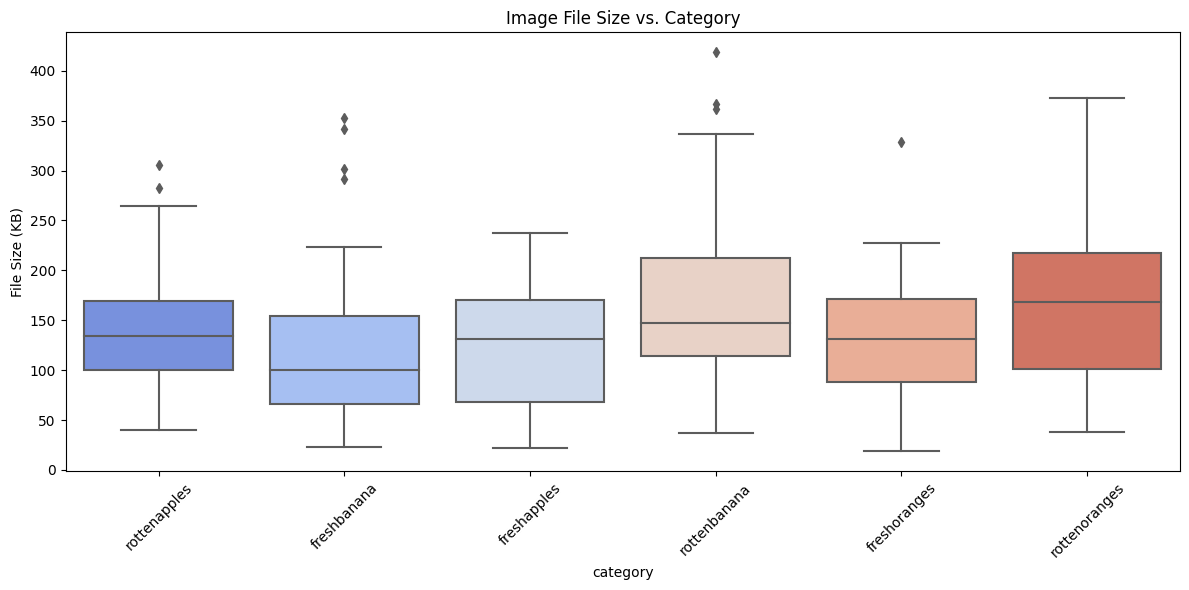

In [18]:
# ------------------ 4.2 Feature Relationships with Target Class ------------------

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Reuse TARGET_SIZE and train_df from previous code
TARGET_SIZE = (224, 224)

# Updated feature extractor
def extract_features_for_analysis(df):
    features = []
    for path in df['image_path']:
        try:
            img = load_img(path, target_size=TARGET_SIZE)
            img_array = img_to_array(img) / 255.0

            r_mean = np.mean(img_array[:, :, 0])
            g_mean = np.mean(img_array[:, :, 1])
            b_mean = np.mean(img_array[:, :, 2])
            aspect_ratio = img_array.shape[1] / img_array.shape[0]
            file_size_kb = os.path.getsize(path) / 1024

            features.append([
                path, r_mean, g_mean, b_mean, aspect_ratio, file_size_kb
            ])
        except Exception as e:
            print(f"Skipping image {path} due to error: {e}")
            continue

    feature_df = pd.DataFrame(features, columns=[
        'image_path', 'R_mean', 'G_mean', 'B_mean', 'aspect_ratio', 'file_size_kb'
    ])
    return df.merge(feature_df, on='image_path', how='inner')

# Sample a subset for faster analysis
sample_df = train_df.sample(500, random_state=42)
analyze_df = extract_features_for_analysis(sample_df)

# ----------- 1. RGB Mean vs Category -----------

plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='R_mean', palette='Reds')
plt.xticks(rotation=45)
plt.title('Red Channel Mean vs. Category')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='G_mean', palette='Greens')
plt.xticks(rotation=45)
plt.title('Green Channel Mean vs. Category')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='B_mean', palette='Blues')
plt.xticks(rotation=45)
plt.title('Blue Channel Mean vs. Category')
plt.tight_layout()
plt.show()

# ----------- 2. Aspect Ratio vs Category -----------

plt.figure(figsize=(12, 6))
sns.violinplot(data=analyze_df, x='category', y='aspect_ratio', palette='pastel')
plt.xticks(rotation=45)
plt.title('Aspect Ratio Distribution by Category')
plt.tight_layout()
plt.show()

# ----------- 3. File Size vs Category -----------

plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='file_size_kb', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Image File Size vs. Category')
plt.ylabel('File Size (KB)')
plt.tight_layout()
plt.show()


In [19]:
import cv2

# Extended feature extractor with HSV
def extract_features_with_hsv(df):
    features = []
    for path in df['image_path']:
        try:
            img = load_img(path, target_size=TARGET_SIZE)
            img_array = img_to_array(img) / 255.0  # RGB normalized

            # RGB stats
            r_mean = np.mean(img_array[:, :, 0])
            g_mean = np.mean(img_array[:, :, 1])
            b_mean = np.mean(img_array[:, :, 2])
            aspect_ratio = img_array.shape[1] / img_array.shape[0]
            file_size_kb = os.path.getsize(path) / 1024

            # Convert to HSV using OpenCV (requires uint8 and BGR format)
            img_uint8 = (img_array * 255).astype(np.uint8)
            img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
            img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

            h_mean = np.mean(img_hsv[:, :, 0])  # Hue
            s_mean = np.mean(img_hsv[:, :, 1])  # Saturation
            v_mean = np.mean(img_hsv[:, :, 2])  # Value

            features.append([
                path, r_mean, g_mean, b_mean, h_mean, s_mean, v_mean,
                aspect_ratio, file_size_kb
            ])
        except Exception as e:
            print(f"Skipping {path} due to error: {e}")
            continue

    feature_df = pd.DataFrame(features, columns=[
        'image_path', 'R_mean', 'G_mean', 'B_mean',
        'H_mean', 'S_mean', 'V_mean',
        'aspect_ratio', 'file_size_kb'
    ])
    return df.merge(feature_df, on='image_path', how='inner')


In [20]:
# Sample for analysis
sample_df = train_df.sample(500, random_state=42)
analyze_df = extract_features_with_hsv(sample_df)


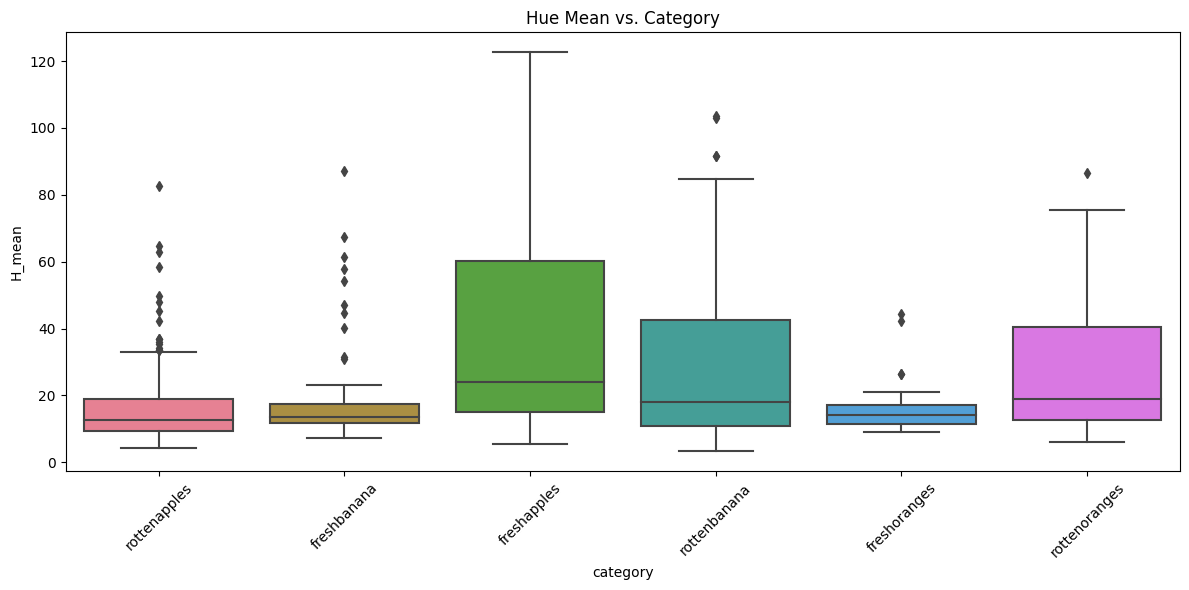

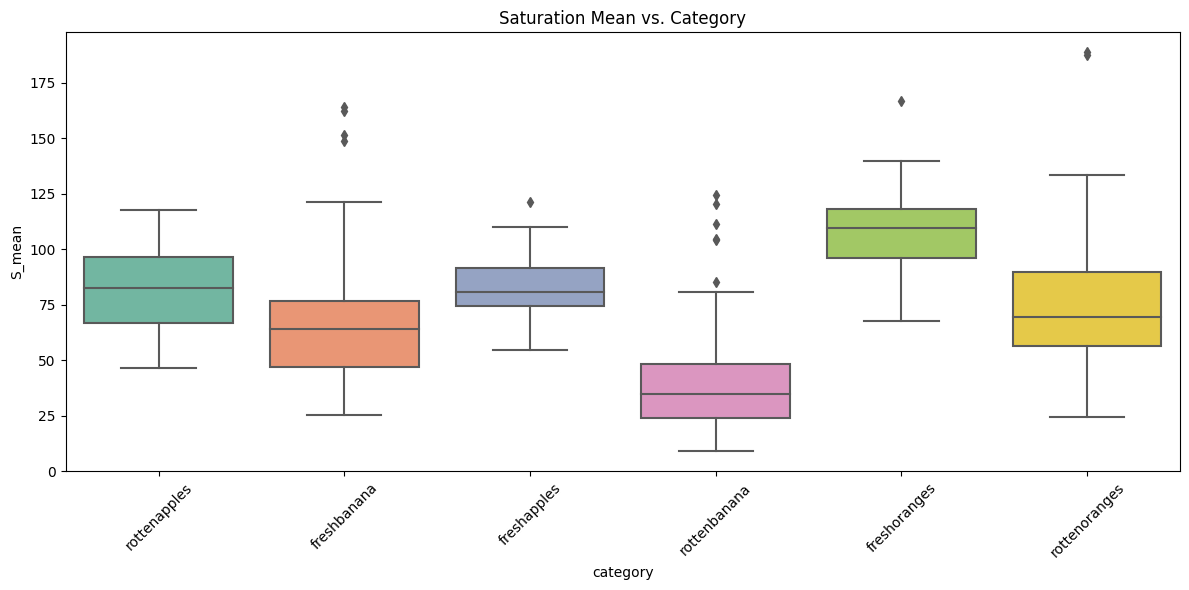

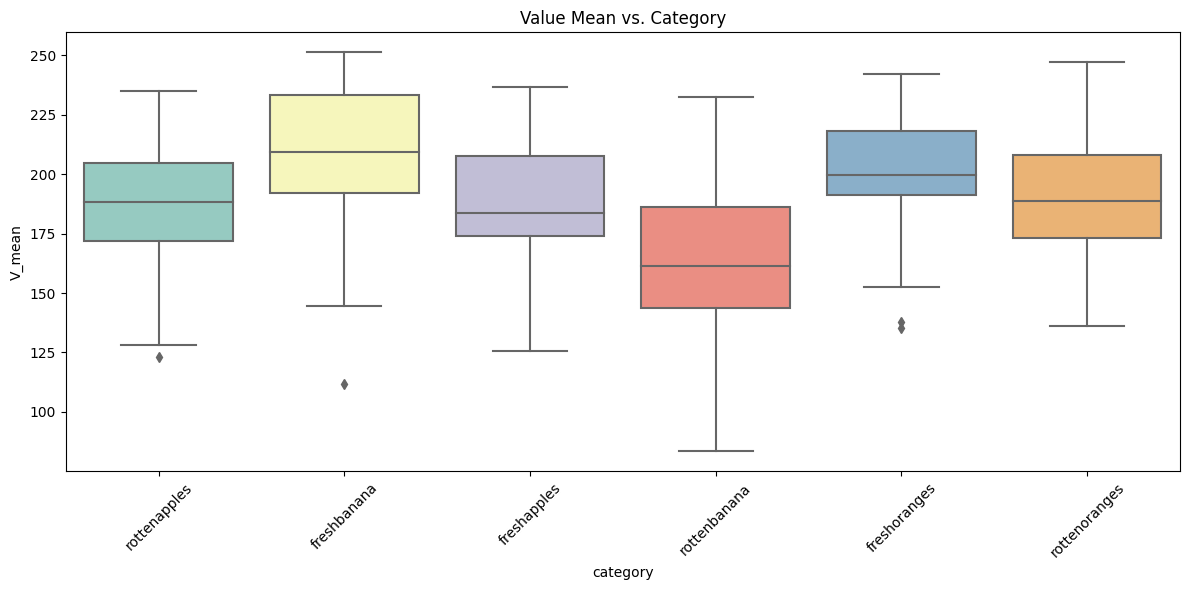

In [21]:
# ----------- HSV Mean vs Category -----------

plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='H_mean', palette='husl')
plt.xticks(rotation=45)
plt.title('Hue Mean vs. Category')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='S_mean', palette='Set2')
plt.xticks(rotation=45)
plt.title('Saturation Mean vs. Category')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='V_mean', palette='Set3')
plt.xticks(rotation=45)
plt.title('Value Mean vs. Category')
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Extract fruit type and freshness class
analyze_df['fruit_type'] = analyze_df['category'].apply(lambda x: x.replace('fresh', '').replace('rotten', ''))
analyze_df['freshness'] = analyze_df['category'].apply(lambda x: 'Fresh' if 'fresh' in x else 'Rotten')

# Step 2: Count flows from fruit type → freshness class
flow_df = analyze_df.groupby(['fruit_type', 'freshness']).size().reset_index(name='count')

# Get unique labels for sankey nodes
labels = list(flow_df['fruit_type'].unique()) + list(flow_df['freshness'].unique())
label_to_index = {label: idx for idx, label in enumerate(labels)}

# Prepare sankey data
source = flow_df['fruit_type'].map(label_to_index)
target = flow_df['freshness'].map(label_to_index)
value = flow_df['count']

# Step 3: Plot the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["#f4a261", "#2a9d8f", "#e76f51", "#2a9d8f", "#e76f51"]  # optional colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="🍎 Fruit Type ↔ Freshness Composition (Alluvial Flow)", font_size=14)
fig.show()


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater




🚨 Detected 23 outliers (Z-score > 3) in cleaned data


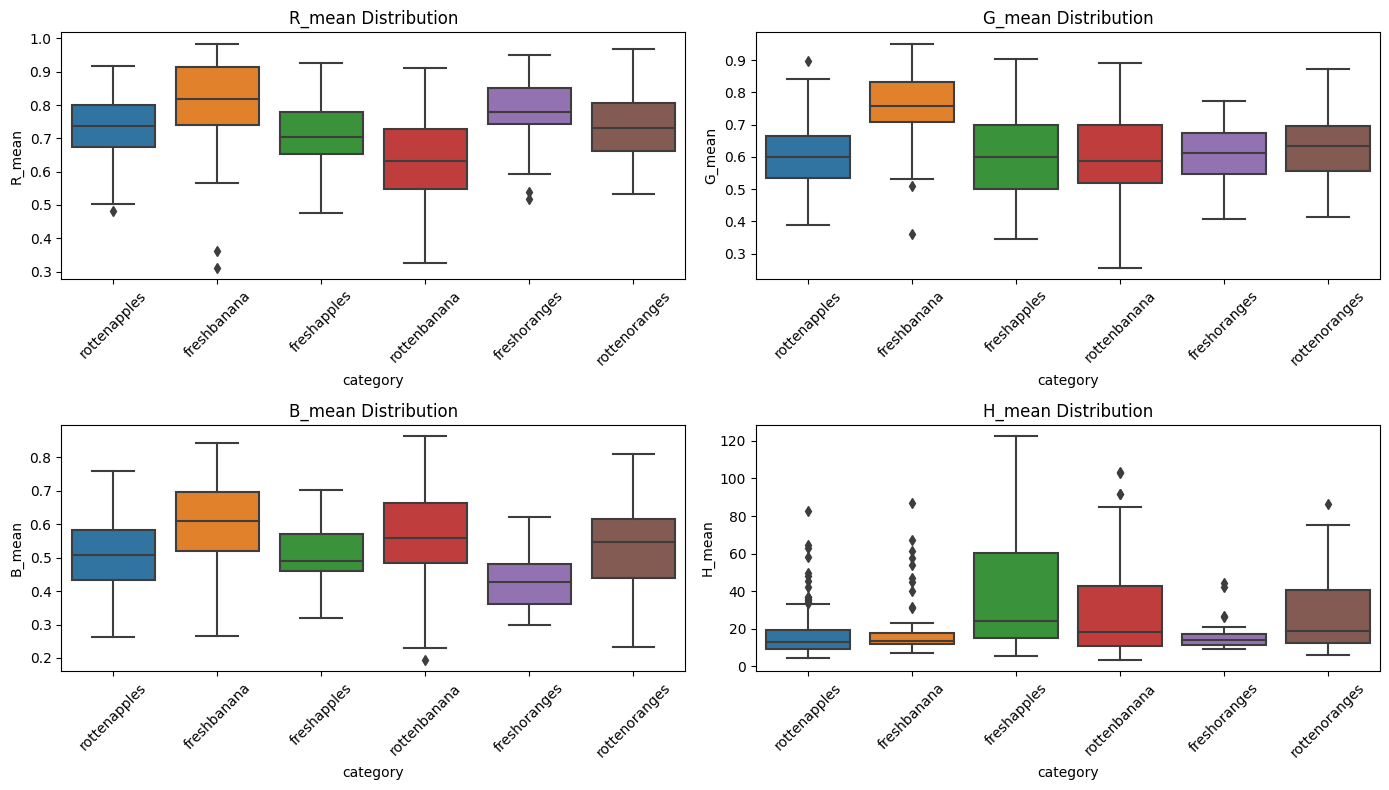

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

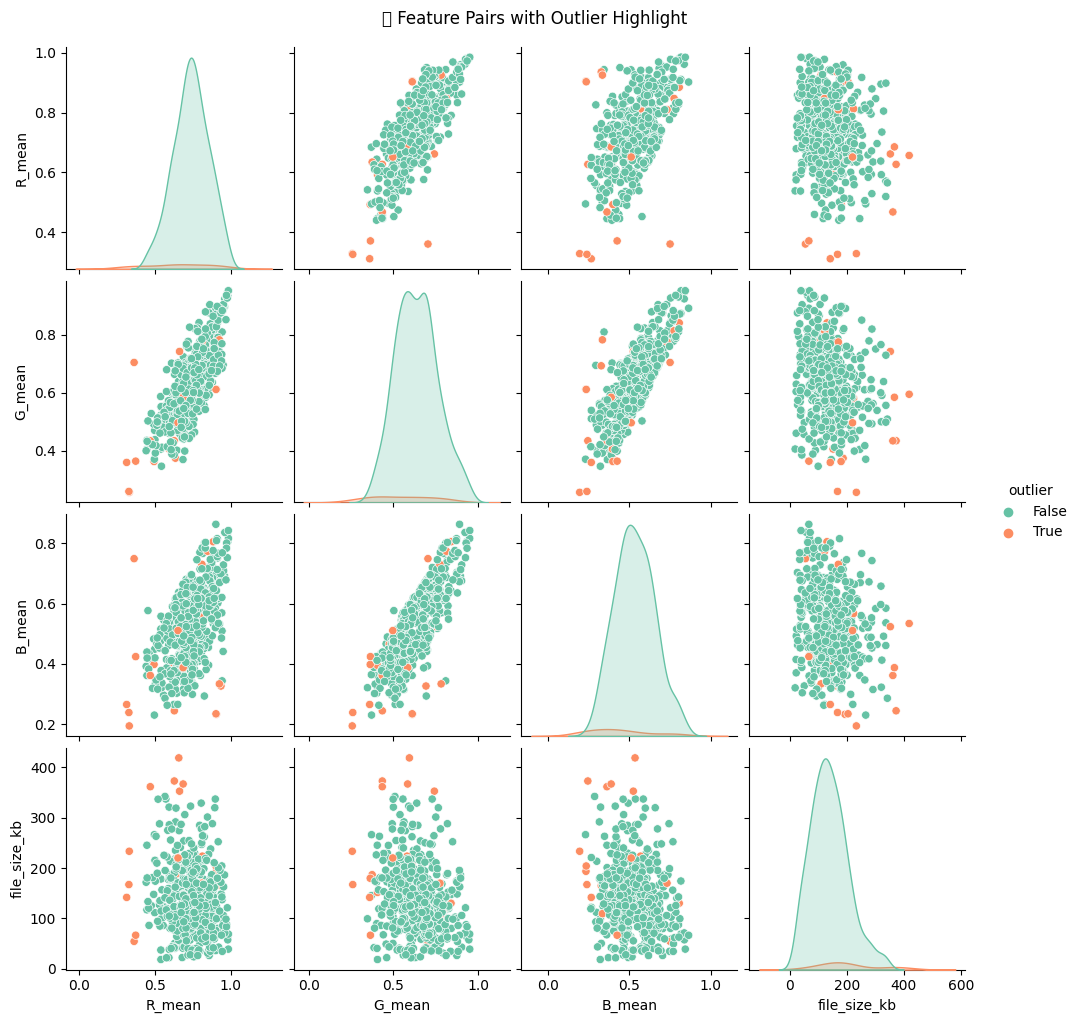

✅ Outliers saved to 'flagged_outliers.csv'


In [25]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Step 1: Define numeric features ----------
numeric_cols = ['R_mean', 'G_mean', 'B_mean', 'H_mean', 'S_mean', 'V_mean', 'aspect_ratio', 'file_size_kb']

# ---------- Step 2: Clean the Data ----------
# Remove NaN or inf values to avoid runtime warnings
analyze_df_clean = analyze_df.dropna(subset=numeric_cols)
analyze_df_clean = analyze_df_clean.replace([np.inf, -np.inf], np.nan)
analyze_df_clean = analyze_df_clean.dropna(subset=numeric_cols)

# ---------- Step 3: Compute Z-scores ----------
z_scores = analyze_df_clean[numeric_cols].apply(zscore)

# Outlier detection: Z-score threshold of 3
outlier_mask = (z_scores.abs() > 3).any(axis=1)

# Print stats
print(f"\n🚨 Detected {outlier_mask.sum()} outliers (Z-score > 3) in cleaned data")

# ---------- Step 4: Split outliers and clean data ----------
outliers_df = analyze_df_clean[outlier_mask]
clean_df = analyze_df_clean[~outlier_mask]

# Optional: Add a flag to the original analyze_df
analyze_df['is_outlier'] = analyze_df.index.isin(outliers_df.index)

# ---------- Step 5: Visualize Outliers (Boxplots) ----------
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols[:4], 1):  # First 4 features
    plt.subplot(2, 2, i)
    sns.boxplot(data=analyze_df_clean, x='category', y=col)
    plt.xticks(rotation=45)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# ---------- Step 6: Visualize with Pairplot ----------
sns.pairplot(analyze_df_clean.assign(outlier=outlier_mask.astype(str)),
             vars=['R_mean', 'G_mean', 'B_mean', 'file_size_kb'],
             hue='outlier', palette='Set2')
plt.suptitle("📊 Feature Pairs with Outlier Highlight", y=1.02)
plt.show()

# ---------- Step 7: Save outliers (Optional) ----------
outliers_df[['image_path', 'category'] + numeric_cols].to_csv("flagged_outliers.csv", index=False)
print("✅ Outliers saved to 'flagged_outliers.csv'")


<ipython-input-26-f4d5ca56f347>:17: UserWarning:

Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.



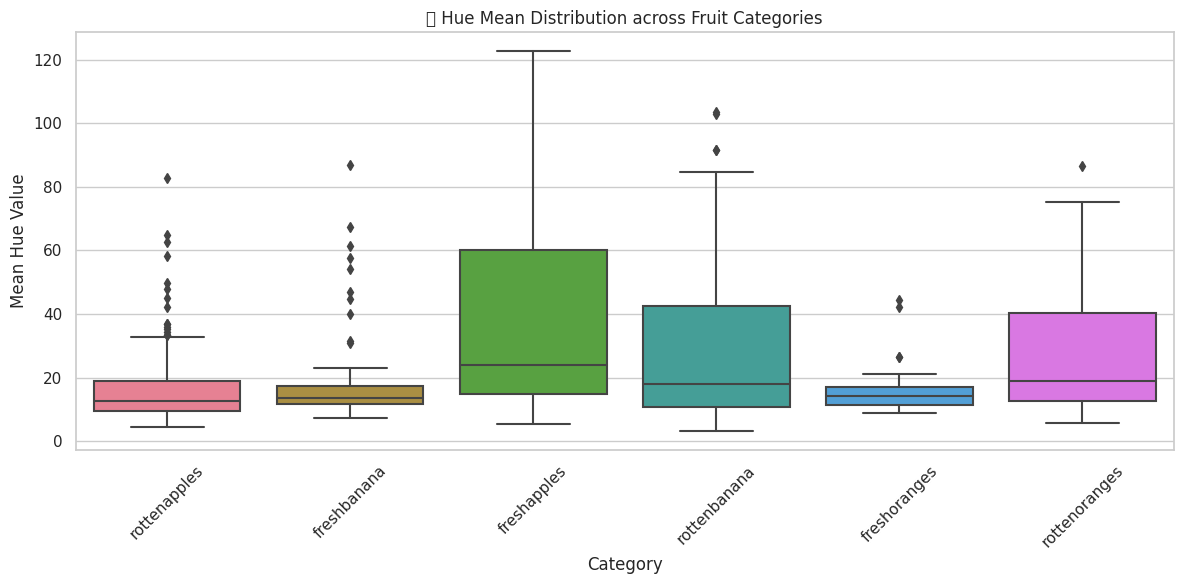

<ipython-input-26-f4d5ca56f347>:27: UserWarning:

Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.



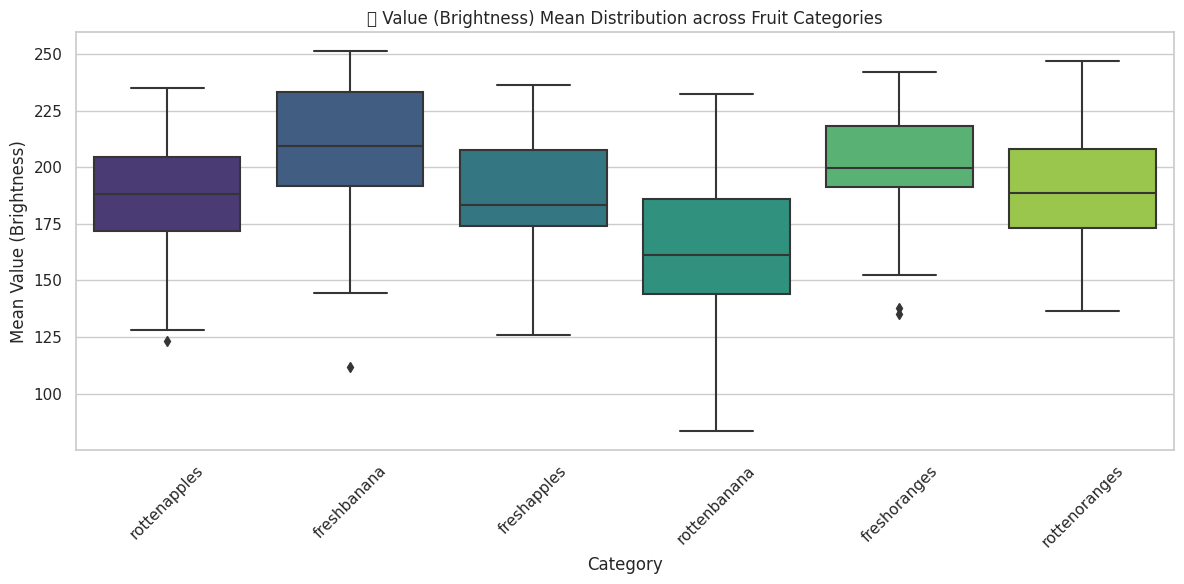

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure we have H_mean and V_mean in the DataFrame
assert 'H_mean' in analyze_df.columns and 'V_mean' in analyze_df.columns, "HSV features missing in analyze_df"

# Set a nice theme
sns.set(style='whitegrid')

# ------- 1. Hue Distribution -------
plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='H_mean', palette='husl')
plt.xticks(rotation=45)
plt.title("🎨 Hue Mean Distribution across Fruit Categories")
plt.xlabel("Category")
plt.ylabel("Mean Hue Value")
plt.tight_layout()
plt.show()

# ------- 2. Value (Brightness) Distribution -------
plt.figure(figsize=(12, 6))
sns.boxplot(data=analyze_df, x='category', y='V_mean', palette='viridis')
plt.xticks(rotation=45)
plt.title("💡 Value (Brightness) Mean Distribution across Fruit Categories")
plt.xlabel("Category")
plt.ylabel("Mean Value (Brightness)")
plt.tight_layout()
plt.show()


<ipython-input-28-c19492255649>:6: UserWarning:

Glyph 127931 (\N{VIOLIN}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127931 (\N{VIOLIN}) missing from current font.



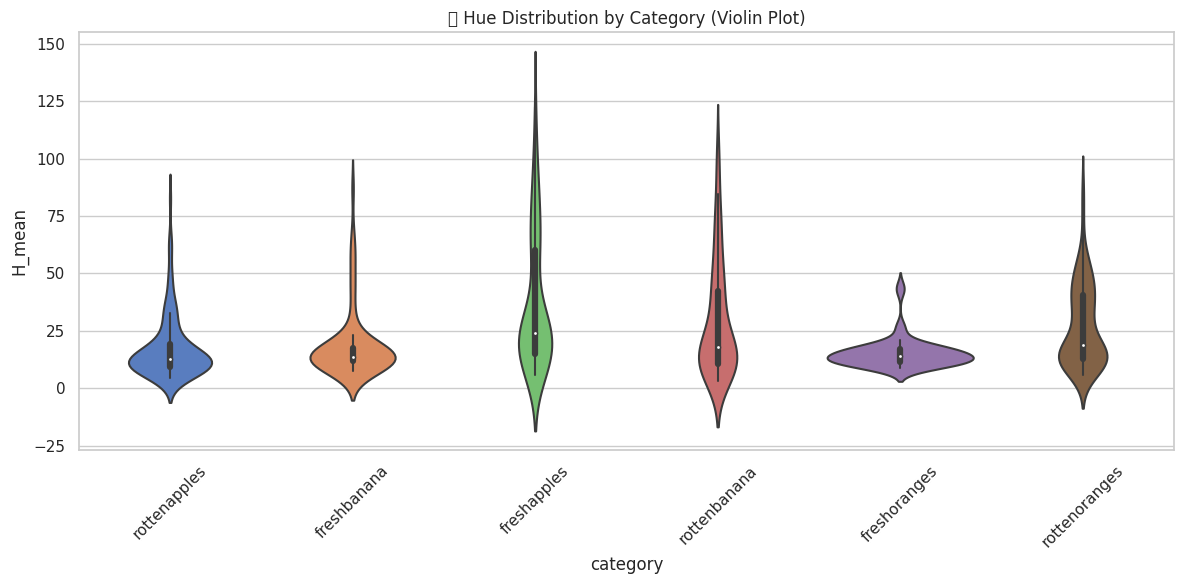

<ipython-input-28-c19492255649>:14: UserWarning:

Glyph 127931 (\N{VIOLIN}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127931 (\N{VIOLIN}) missing from current font.



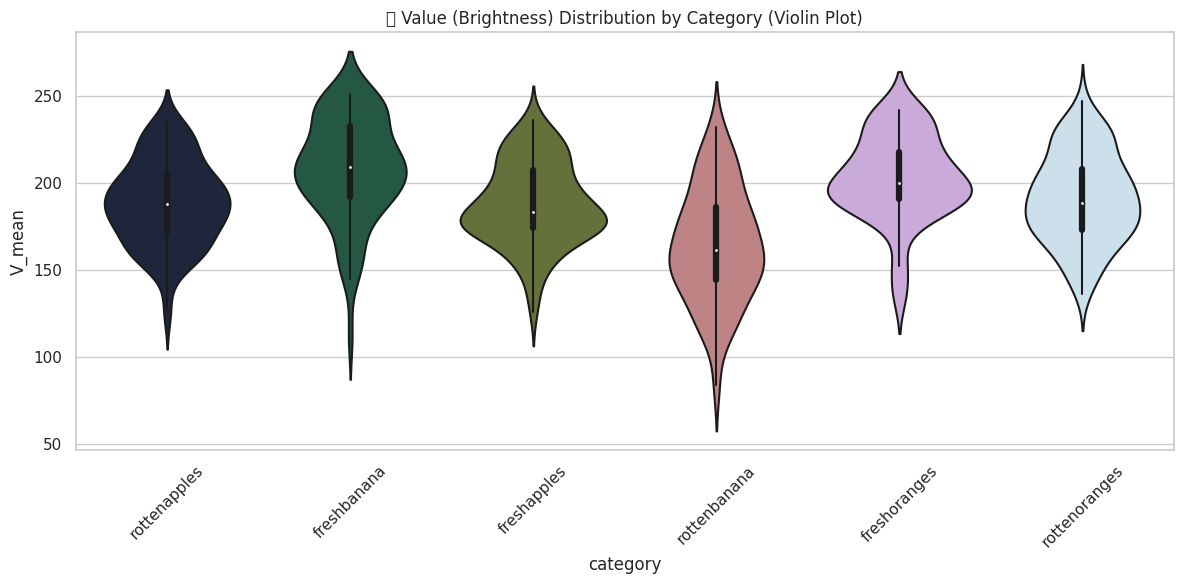

In [28]:
# Violin plot for Hue
plt.figure(figsize=(12, 6))
sns.violinplot(data=analyze_df, x='category', y='H_mean', palette='muted')
plt.title("🎻 Hue Distribution by Category (Violin Plot)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Violin plot for Value
plt.figure(figsize=(12, 6))
sns.violinplot(data=analyze_df, x='category', y='V_mean', palette='cubehelix')
plt.title("🎻 Value (Brightness) Distribution by Category (Violin Plot)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
